In [290]:
import numpy as np
import sympy as sp
import random
from typing import Callable, Tuple
import matplotlib.pyplot as plt

# Простий градієнтний спуск

Перед застосуванням градієнтного спуску оголосимо функцію $E$ та її градієнт

In [291]:
w1, w2 = sp.symbols('w1 w2')
sigma, a, b = sp.symbols('sigma a b')
R11, R12, R21, R22 = sp.symbols('R11 R12 R21 R22')

R = sp.Matrix([[R11, R12], [R21, R22]])
w_vec = sp.Matrix([w1, w2])
quadratic_form = (w_vec.T * R * w_vec)[0, 0]

E_expr = 1/2 * sigma ** 2 - (a * w1 + b * w2) + 1/2 * quadratic_form
derivative_w1 = sp.diff(E_expr, w1)
derivative_w2 = sp.diff(E_expr, w2)

gradE = sp.lambdify((w1, w2, sigma, a, b, R11, R12, R21, R22), [derivative_w1, derivative_w2], 'numpy')

In [292]:
sigma = np.random.rand(); a = 0.9; b = 0.2; c = 0.6; R = np.matrix([[1, c], [c, 1]]); eta = 0.4; precision = 1e-3

E = lambda w: 1 / 2 * sigma ** 2 - np.array([a,b]) @ w + 1 / 2 * np.transpose(w) @ R @ w
print(f'E = 1 / 2 * {sigma} ** 2 - {np.array([a, b])} * w + 1 / 2 * wT * {R} * w')

E = 1 / 2 * 0.30212245377760905 ** 2 - [0.9 0.2] * w + 1 / 2 * wT * [[1.  0.6]
 [0.6 1. ]] * w


Тепер можна запускати алгоритм градієнтного спуску. Умова зупинки - $\|w(k) - w(k+1)\|<0.001$

In [293]:
def gradient_descent(
        E: Callable[[np.ndarray], np.ndarray],
        gradE: Callable[[float, float, float, float, float, float, float, float, float], Tuple[float, float]],
        precision: float,
        eta: float,
        maxsteps=500
    ) -> (np.ndarray, bool):
    i = 0 # Номер ітерації
    w_i = [] # Список точок для побудови траекторій
    w = np.array([random.uniform(-10, 10), random.uniform(-10, 10)]) # Обираємо початкову точку випадково
    print(f'starting target function value = {E(w)}\n')
    eps = 1 # Змінна, що відслідковує норму різниці w(k) і w(k-1)

    while eps >= precision:
        if i >= maxsteps: # Якщо досягнено заданої кількості кроків - зупинити виконання передчасно
            return w_i
        i += 1
        print(f'iteration = {i}')
        grad = gradE(*w, sigma, a, b, R[0, 0], R[0, 1], R[1, 0], R[1, 1]) # Обчислення градієнту в поточній точці
        print(f'gradient of E in {w} = {grad}')
        w_new = w - eta * np.array(grad) # Оновлення точки
        print(f'updated w:  w = {w_new}')
        eps = np.linalg.norm(w - w_new)
        print(f'E(w) = {E(w_new)}')
        print(f'eps = {eps}\n')
        w = w_new

        w_i.append(w) # Додаємо стару точку до списку

    return w_i


descent_trajectory = gradient_descent(E, gradE, precision, eta)

starting target function value = [[65.27099864]]

iteration = 1
gradient of E in [-4.02375469 -8.05587731] = [np.float64(-9.757281073546157), np.float64(-10.670130123630774)]
updated w:  w = [-0.12084226 -3.78782526]
E(w) = [[8.36771122]]
eps = 5.7835105021555195

iteration = 2
gradient of E in [-0.12084226 -3.78782526] = [np.float64(-3.2935374144563077), np.float64(-4.060330616527388)]
updated w:  w = [ 1.19657271 -2.16369302]
E(w) = [[0.9047294]]
eps = 2.091264628532055

iteration = 3
gradient of E in [ 1.19657271 -2.16369302] = [np.float64(-1.0016431007072115), np.float64(-1.645749390446919)]
updated w:  w = [ 1.59722995 -1.50539326]
E(w) = [[-0.12478865]]
eps = 0.7706392107699438

iteration = 4
gradient of E in [ 1.59722995 -1.50539326] = [np.float64(-0.20600600671706648), np.float64(-0.7470552900984206)]
updated w:  w = [ 1.67963235 -1.20657114]
E(w) = [[-0.30218408]]
eps = 0.3099755038753991

iteration = 5
gradient of E in [ 1.67963235 -1.20657114] = [np.float64(0.055689665593381

Алгоритм збігся, не досягши максимальної кількості ітерацій.

Створюємо функцію для зображення траекторій вектору w протягом роботи алгоритму

In [294]:
def plot_descent(w_i: np.ndarray, f: Callable[[np.ndarray], np.ndarray], descent_name: str) -> None:
    x_i = np.array([w[0] for w in w_i])
    y_i = np.array([w[1] for w in w_i])
    z_i = np.array([f(w).item() for w in w_i])

    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(descent_name)

    ax = fig.add_subplot(2, 1, 1)

    ax.plot(x_i, y_i)
    ax.scatter(x_i[0], y_i[0], color='green', s=20, label='Початок')
    if len(z_i) < 500:
        ax.scatter(x_i[-1], y_i[-1], color='red', s=20, label='Мінімум')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Trajectory of w(t) in W')
    ax.legend()
    ax.grid(True)
    ax.axis('equal')

    ax = fig.add_subplot(2, 1, 2, projection='3d')

    # Адаптивні межі графіку
    margin = abs(x_i.min() - x_i.max()) * 0.1
    x_min, x_max = x_i.min() - margin, x_i.max() + margin
    margin = abs(y_i.min() - y_i.max()) * 0.1
    y_min, y_max = y_i.min() - margin, y_i.max() + margin

    x_vals = np.linspace(x_min, x_max, 50)
    y_vals = np.linspace(y_min, y_max, 50)
    X, Y = np.meshgrid(x_vals, y_vals)

    X_flat = X.flatten()
    Y_flat = Y.flatten()
    points = np.column_stack((X_flat, Y_flat))
    Z_flat = np.array([f(point) for point in points])

    Z = Z_flat.reshape(X.shape)

    z_min, z_max = Z.min(), Z.max()
    z_range = z_max - z_min
    ax.set_zlim(z_min - 0.005 * z_range, z_max + 0.005 * z_range)

    surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis', linewidth=0)

    ax.plot(x_i, y_i, z_i, 'r-', linewidth=3, markersize=4, label='Траєкторія')
    ax.scatter(x_i[0], y_i[0], z_i[0], color='green', s=20, label='Початок')
    if len(z_i) < 500:
        ax.scatter(x_i[-1], y_i[-1], z_i[-1], color='red', s=20, label='Мінімум')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('E')
    ax.set_title('Trajectory of w(t) in 3D space')
    ax.legend(loc='upper right')

    plt.show()

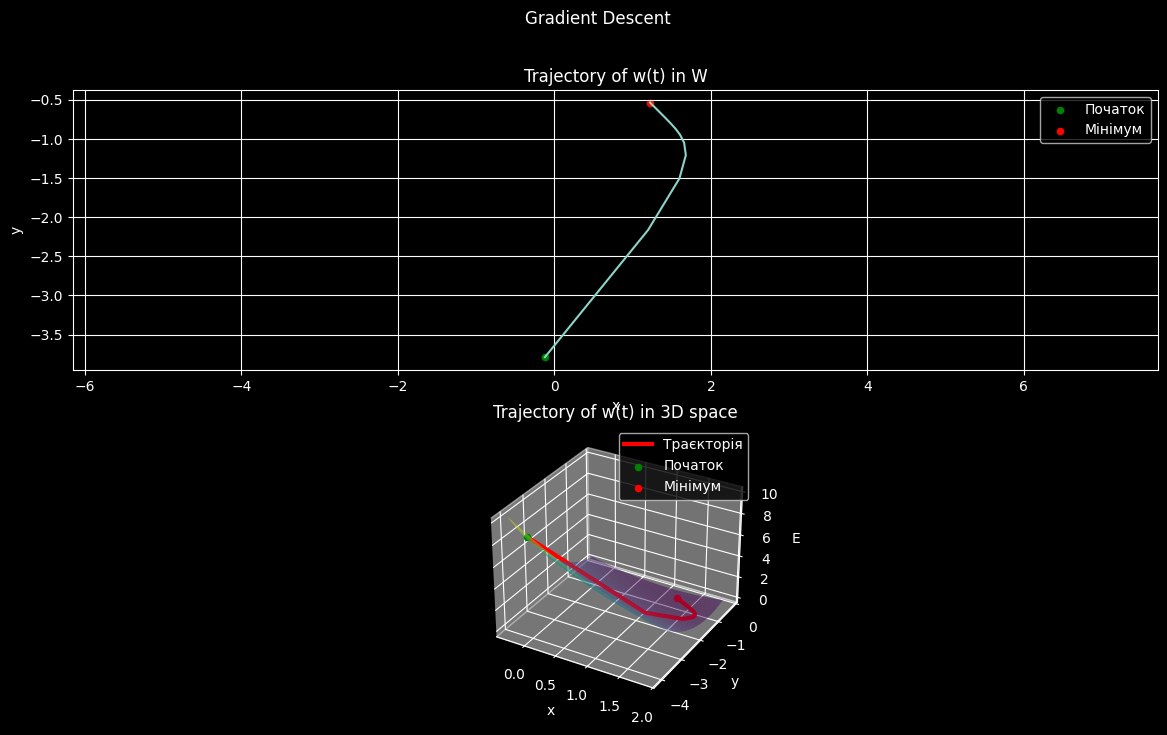

In [295]:
plot_descent(descent_trajectory, E, 'Gradient Descent')

Знайдемо точне значення $w^*$ за допомогою нормального рівняння $w^*=R^{-1}p$

In [296]:
rho = np.array([a,b])
R_I = np.linalg.inv(R)

w_opt = R_I @ rho
w_opt

matrix([[ 1.21875, -0.53125]])

Порівняємо зі знайденим за допомогою градієнтного спуску мінімумом

In [297]:
print(f'Чисельно знайдена точка мінімуму: {descent_trajectory[-1]}')
print(f'Вектор різниці між точкою w* і знайденою точкою мінімуму: {w_opt - descent_trajectory[-1]}')
print(f'Норма вектора різниці: {np.linalg.norm(w_opt - descent_trajectory[-1])}')

Чисельно знайдена точка мінімуму: [ 1.22236847 -0.53486847]
Вектор різниці між точкою w* і знайденою точкою мінімуму: [[-0.00361847  0.00361847]]
Норма вектора різниці: 0.005117294588788896


Обчислимо власні числа матриці автокореляцій R

In [298]:
lambdas = np.linalg.eigvals(R)
lambda_max = max(lambdas)
lambda_min = min(lambdas)

In [299]:
print(f'Алгоритм має збігатися при 0 < eta < {2 / lambda_max}')

Алгоритм має збігатися при 0 < eta < 1.25


In [300]:
eta = 2/lambda_max*0.95
conv_desc = gradient_descent(E, gradE, precision, eta)

starting target function value = [[84.11868453]]

iteration = 1
gradient of E in [-6.90864123 -6.91811157] = [np.float64(-11.959508169691956), np.float64(-11.263296303696652)]
updated w:  w = [7.29327472 6.4570528 ]
E(w) = [[67.88881061]]
eps = 19.50870160640784

iteration = 2
gradient of E in [7.29327472 6.4570528 ] = [np.float64(10.267506398201105), np.float64(10.633017627848641)]
updated w:  w = [-4.89938913 -6.16965564]
E(w) = [[54.85987883]]
eps = 17.552629932883928

iteration = 3
gradient of E in [-4.89938913 -6.16965564] = [np.float64(-9.501182509504863), np.float64(-9.309289113939908)]
updated w:  w = [6.3832651  4.88512518]
E(w) = [[44.33876555]]
eps = 15.79577365990028

iteration = 4
gradient of E in [6.3832651  4.88512518] = [np.float64(8.414340214214347), np.float64(8.515084246885948)]
updated w:  w = [-3.6087639  -5.22653736]
E(w) = [[35.8255724]]
eps = 14.215708319019914

iteration = 5
gradient of E in [-3.6087639  -5.22653736] = [np.float64(-7.644686316071428), np.float6

In [301]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(conv_desc[-1] - w_opt)}')

eta: 1.1875
Норма відстані до w*: 0.0004616555721758594


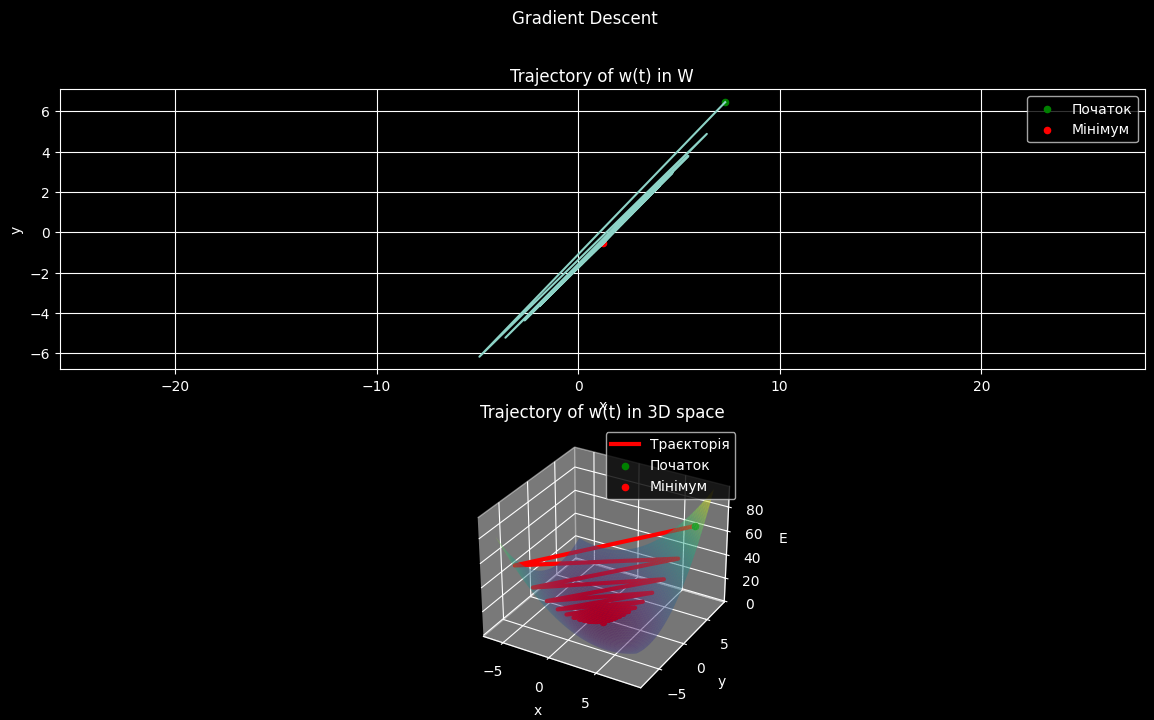

In [302]:
plot_descent(conv_desc, E, 'Gradient Descent')

Отже, при $\eta < 1.25$ алгоритм градієнтного спуску дійсно збігається

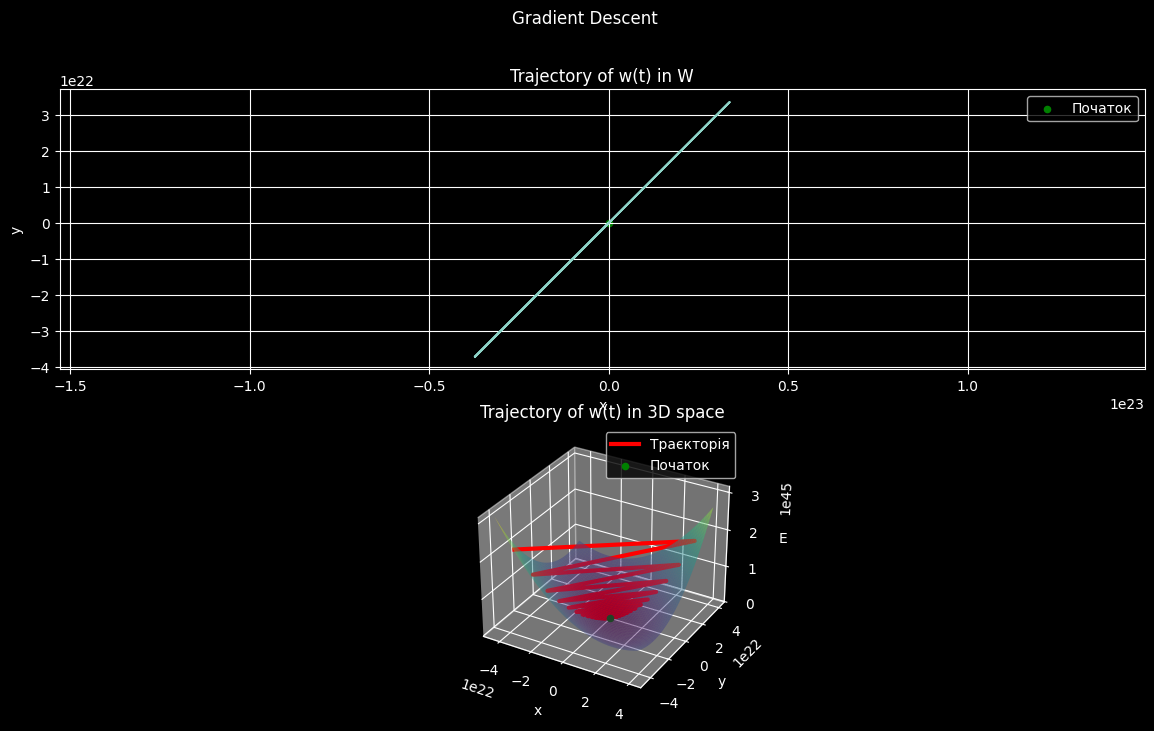

In [303]:
eta = 2/lambda_max/0.95
div_desc = gradient_descent(E, gradE, precision, eta)
plot_descent(div_desc, E, 'Gradient Descent')

In [304]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(div_desc[-1] - w_opt)}')

eta: 1.3157894736842106
Норма відстані до w*: 5.2659294227714286e+22


При $\eta > 1.25$ алгоритм градієнтного спуску розбігається

Оцінимо швидкість збіжності. Для цього знайдемо частку $\frac{\lambda_{min}}{\lambda_{max}}$, де $\lambda_{max}$ - максимальне власне число матриці $R$, а $\lambda_{min}$ - мінімальне.

In [305]:
print(lambda_min/lambda_max)

0.25000000000000006


Отримали значення ближче до нуля, що означає помірно повільну збіжність алгоритму.

# Adam Gradient Descent

In [316]:
def adam_gradient_descent(
        E: Callable[[np.ndarray], np.ndarray],
        gradE: Callable[[float, float, float, float, float, float, float, float, float], Tuple[float, float]],
        precision: float,
        eta: float,
        beta1=0.9,
        beta2=0.999,
        vareps=1e-8,
        maxsteps=500
    ) -> (np.ndarray, bool):
    i = 0 # Номер ітерації
    w_i = [] # Список точок для побудови траекторій
    w = np.array([random.uniform(-10, 10), random.uniform(-10, 10)]) # Обираємо початкову точку випадково
    print(f'starting target function value = {E(w)}\n')
    eps = 1 # Змінна, що відслідковує норму різниці w(k) і w(k-1)
    m = np.zeros_like(w); v = np.zeros_like(w)


    while eps >= precision:
        if i >= maxsteps: # Якщо досягнено заданої кількості кроків - зупинити виконання передчасно
            return w_i
        i += 1
        print(f'iteration = {i}')
        g = np.array(gradE(*w, sigma, a, b, R[0, 0], R[0, 1], R[1, 0], R[1, 1])) # Обчислення градієнту в поточній точці
        print(f'gradient in {w} = {g}')
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        mt = m / (1 - beta1**i)
        vt = v / (1 - beta2**i)
        delta_w = - (eta * mt) / (np.sqrt(vt + vareps))
        print(f'delta w = {delta_w}')
        w_new = w + delta_w # Оновлення точки
        print(f'updated w:  w = {w_new}')
        eps = np.linalg.norm(w - w_new)
        print(f'E(w) = {E(w_new)}')
        print(f'eps = {eps}\n')
        w = w_new

        w_i.append(w) # Додаємо стару точку до списку

    return w_i

eta=0.4
descent_trajectory = adam_gradient_descent(E, gradE, precision, eta)

starting target function value = [[71.41704392]]

iteration = 1
gradient in [-3.1918921  -9.34274527] = [ -9.69753926 -11.45788052]
delta w = [0.4 0.4]
updated w:  w = [-2.7918921  -8.94274527]
E(w) = [[63.21087601]]
eps = 0.5656854249234281

iteration = 2
gradient in [-2.7918921  -8.94274527] = [ -9.05753926 -10.81788052]
delta w = [0.39905613 0.39923613]
updated w:  w = [-2.39283596 -8.54350913]
E(w) = [[55.53242883]]
eps = 0.5644778901371652

iteration = 3
gradient in [-2.39283596 -8.54350913] = [ -8.41894144 -10.17921071]
delta w = [0.39738012 0.3978954 ]
updated w:  w = [-1.99545584 -8.14561373]
E(w) = [[48.389633]]
eps = 0.5623448344540053

iteration = 4
gradient in [-1.99545584 -8.14561373] = [-7.78282408 -9.54288723]
delta w = [0.39488639 0.39592363]
updated w:  w = [-1.60056945 -7.74969009]
E(w) = [[41.7881994]]
eps = 0.5591876127359895

iteration = 5
gradient in [-1.60056945 -7.74969009] = [-7.15038351 -8.91003176]
delta w = [0.39148288 0.39326432]
updated w:  w = [-1.2090865

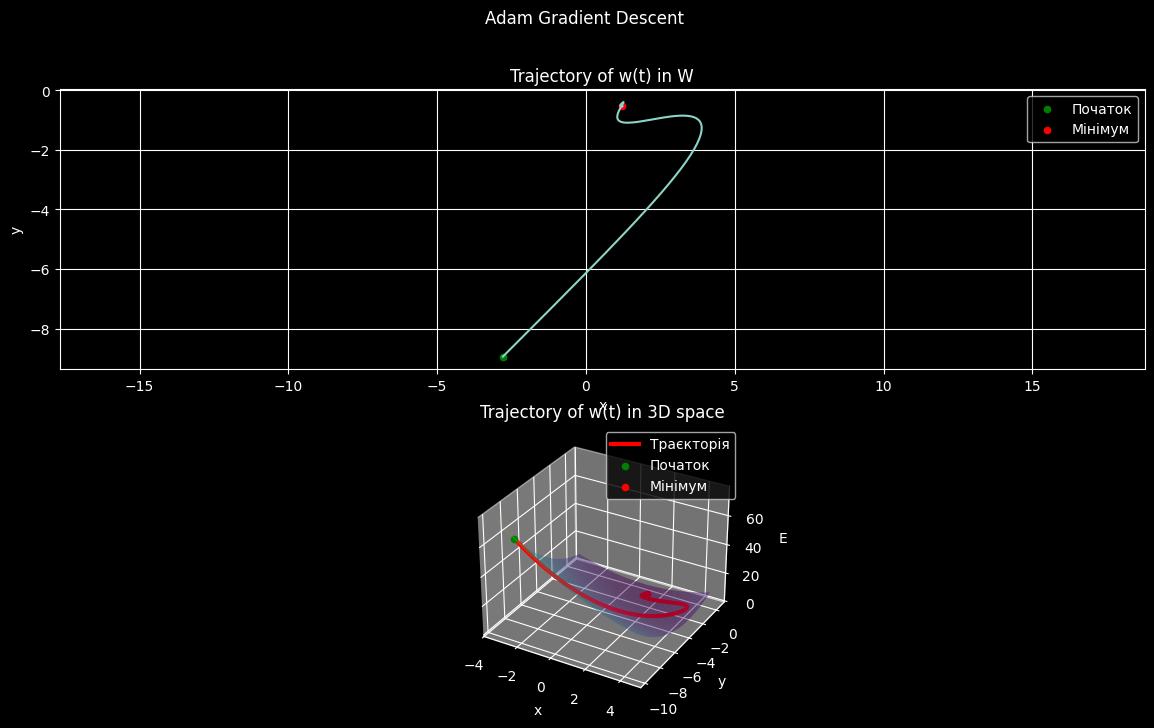

In [317]:
plot_descent(descent_trajectory, E, 'Adam Gradient Descent')

In [319]:
print(f'Норма відстані знайденого мінімуму до w*: {np.linalg.norm(descent_trajectory[-1] - w_opt)}')

Норма відстані знайденого мінімуму до w*: 0.007445808597541094


Спробуємо підібрати таке значення кроку, щоб алгоритм розбігався

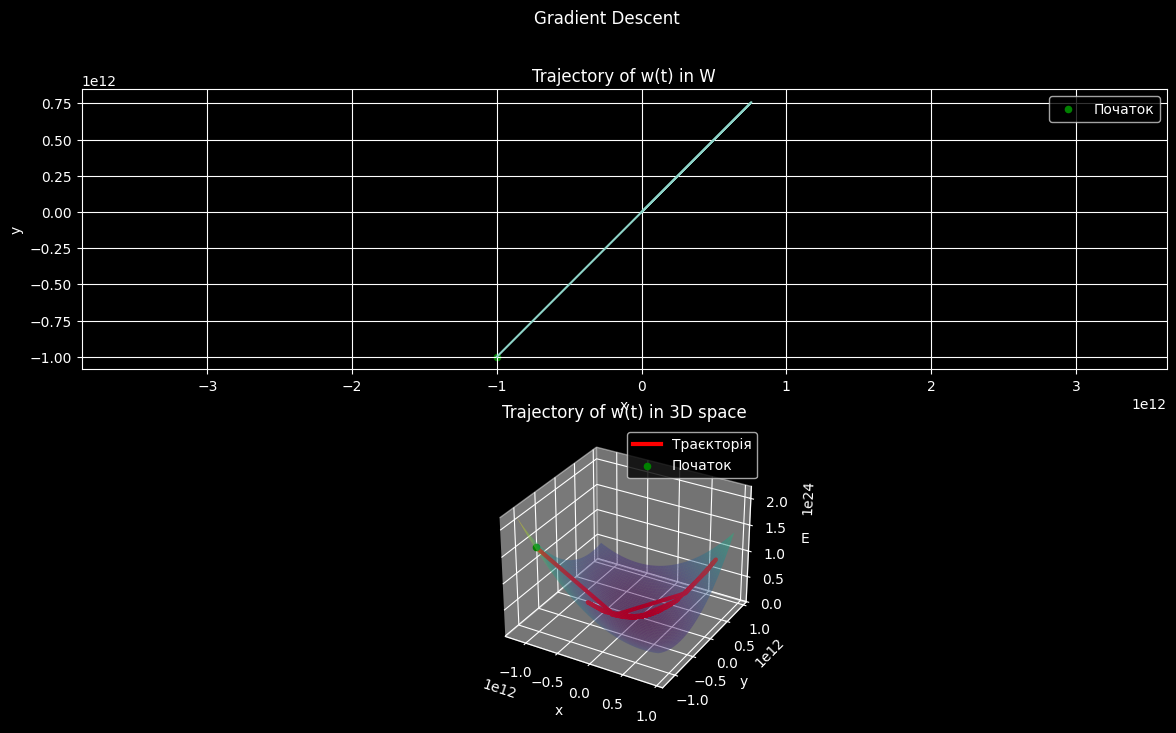

In [350]:
eta = 1e12
div_desc = adam_gradient_descent(E, gradE, precision, eta)
plot_descent(div_desc, E, 'Gradient Descent')

In [351]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(div_desc[-1] - w_opt)}')

eta: 1000000000000.0
Норма відстані до w*: 7.325264716535188


При $\eta = 10^{12}$ алгоритм не встиг збігтись за задану кількість максимальних кроків, однак за траекторією видно, що ваги не "вибухнули" і не стали збільшуватись до нескінченності, як це було у випадку з розбіжністю у звичайного градієнта, а залишались поблизу точки мінімуму (норма різниці дорівнює 7.32).

Можна зробити висновок, що Adam набагато стабільніший до змін параметру довжини кроку